In [1]:
import torch 
from torch import Tensor 
import numpy as np
import math
import matplotlib.pyplot as plt

## Data Generation

In [2]:
data = torch.FloatTensor(1000,2).uniform_(0,1)
distance = torch.sqrt(torch.pow(data.narrow(1,0,1), 2) + torch.pow(data.narrow(1,1,1),2))
radius = 1 / math.sqrt(2 * math.pi)
inside = distance.clone().apply_(lambda x : 0 if x > radius else  1)
outside = distance.clone().apply_(lambda x : 1 if x > radius else  0)

target = torch.cat((inside, outside), 1)

In [3]:
data


 0.5876  0.7185
 0.8942  0.0439
 0.9957  0.6826
       ⋮        
 0.3628  0.1018
 0.8578  0.8672
 0.6715  0.8947
[torch.FloatTensor of size 1000x2]

In [4]:
distance



 0.9281
 0.8953
 1.2072
   ⋮    
 0.3768
 1.2198
 1.1186
[torch.FloatTensor of size 1000x1]

In [5]:
radius

0.3989422804014327

In [6]:
target



    0     1
    0     1
    0     1
     ⋮      
    1     0
    0     1
    0     1
[torch.FloatTensor of size 1000x2]

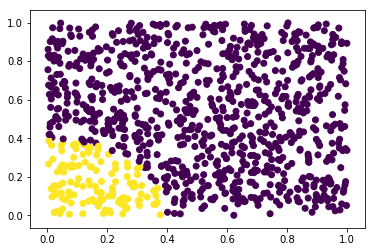

In [7]:
plt.scatter(data[:,0], data[:,1], c=inside)
plt.show()

## ReLu

In [3]:
class Relu:
    
    def forward(self, X):   
        return X.clamp(min=0)
    
    def backward(self, dz):
        output = dz.clone()
        output[output > 0] = 1
        output[output <= 0] = 0
        return output
    

## Tanh Module


In [5]:
class Tanh:
    
    def forward(self, X):
        self.output = Tensor.tanh(X)
        return self.output;

    def backward(self, dz):
        return (1.0 - Tensor.pow(self.output,2)) * dz
        

## LossMSE Module

In [5]:
class LossMSE: 
        
    def forward(self, t, x):
        loss = (t - x).pow(2).sum()
        return loss
    
    def backward(self, t, x):
        return - 2 * (t - x)

## Linear Module

In [6]:
class Linear:
    
    def __init__(self, input_size ,hidden_nodes):    
        
        # Initialize weight, bias
        self.w = Tensor(hidden_nodes, input_size).normal_(0,1e-6)
        self.b = Tensor(hidden_nodes).normal_(0,1e-6)
        
    def forward(self, x):
        self.x = x
        s = x.mm(self.w.t()) + self.b
        return s
        
    def backward(self, dz, lambda_):
        
        self.dx = dz.mm(self.w)
        dw = self.x.t().mm(dz)
        db = dz.t().sum(1).squeeze_()
        
        # update weight and bias
        self.w = self.w - lambda_ * dw
        self.b = self.b - lambda_ * db
    
        return self.dx
        
    def params(self):
        return (self.w, self.b)
    
    
    

## Sequential Module

In [ ]:
class Sequential:
    
    def __init__(self,modules, epsilon, optimizer):
        self.modules = modules
        self.optimizer = optimizer

    def forward(self, x_input):
        result = x_input
        for m in modules: 
            result = m.forward(result)
            result = self.optimizer.forward(result)
        return result
    
    def backward(self, dz,lambda_):
        self.dz = dz
        for m in self.modules[::-1]:
            self.dz = self.optimizer.forward(self.dz)
            self.dz = m.backward(self.dz,lambda_)

        

## Trainning

In [89]:
lambda_ = 0.001
train_data, train_target, test_data, test_target = data[0:800,], target[0:800,], data[800:,], target[800:,]
no_iter = 5



modules = list([Linear(2, 25), Linear(25, 25), Linear(25, 25), Linear(25, 2)])

# modules = list([Linear(2,2, lambda_)])

seq = Sequential(modules, 0.01, Tanh())

## SGD 
for n in range(no_iter): 
   
    # Initialize loss function
    loss_mse = LossMSE()
    
    # Random sampling
    randomInt  = np.random.randint(800, size=(1))[0]
    sample_data = train_data[randomInt, :].view(-1,2)
    sample_target = train_target[randomInt, :].view(-1,2)
    

    
    # Forward path
    nn_output = seq.forward(sample_data)
    
    
    train_loss = loss_mse.forward(sample_target,nn_output)
    
    # Backward path (update weight and bias)
    dz = loss_mse.backward(sample_target, nn_output)
    
    seq.backward(dz, lambda_)
    

    # compute train accuracy 
    train_errors = 0
    for i in range(train_data.shape[0]):
        pred = seq.forward(train_data[i,:].view(-1,2)).max(1)[1][0]
        if train_target[i, pred] == 0:
             train_errors += 1
    
    
    # comput test accuracy
    test_errors = 0
    for i in range(test_data.shape[0]):
        print(seq.forward(test_data[i,:].view(-1,2)))
        pred = seq.forward(test_data[i,:].view(-1,2)).max(1)[1][0]
        print(pred)
        if test_target[i, pred] == 0: 
             test_errors += 1
   
    print('{:d} train_loss {:.02f} train_error {:.02f}% test_error {:.02f}%'
          .format(n,
                  train_loss,
                  (100 * train_errors) / train_data.size(0),
                  (100 * test_errors) / test_data.size(0)))




1.00000e-07 *
 -6.1809 -0.1729
[torch.FloatTensor of size 1x2]



Columns 0 to 9 
1.00000e-06 *
  0.0221 -0.8755 -1.8280 -0.0898 -1.7492  0.6725  0.1998 -0.7246 -0.0436 -0.4708
  0.1129  0.7424 -1.3326  0.6104  0.9517  1.3198  0.7912 -0.3325  0.9084  1.8902

Columns 10 to 19 
1.00000e-06 *
  0.7834 -3.3128 -1.5893 -1.5545  0.4043  0.6521  0.5955  1.4652 -0.3822  0.9767
  0.2996 -0.7325 -0.3481  0.8262  1.1655  0.2487  1.6650 -0.5468  1.2336  0.0786

Columns 20 to 24 
1.00000e-06 *
  0.9736 -0.7459 -0.7334 -0.4655  0.7135
  1.2009 -1.3622  0.3039  0.4758  2.5852
[torch.FloatTensor of size 2x25]


1.00000e-07 *
 -6.1809
 -0.1729
[torch.FloatTensor of size 2]

-----

 4.5414e-13  3.5416e-07
-4.3504e-13 -3.3926e-07
 9.9191e-15  7.7353e-09
 1.7308e-12  1.3497e-06
 8.4961e-13  6.6256e-07
 7.5528e-13  5.8900e-07
-9.2721e-13 -7.2308e-07
-1.7554e-13 -1.3690e-07
 1.3883e-12  1.0827e-06
 9.3494e-13  7.2911e-07
 1.5175e-13  1.1834e-07
-4.4899e-13 -3.5014e-07
-1.5156e-12 -1.1819e-06
 2.3748e-13  1

/usr/local/lib/python3.6/site-packages/torch/tensor.py:312: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.sub(other)


1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  1.9279
[torch.FloatTensor of size 1


1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  2.8916
[torch.FloatTensor of size 1x2


1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2]

1

1.00000e-03 *
 -0.0006  4.8187
[torch.FloatTensor of size 1x2